# The Full Bayesian Approach to the GLM-HMM
For simplicity (and identifiability), we fist consider a GLM-HMM with only two states. 

We will use data from one mouse used in the Ashwood et al. (2020) paper to fit the two-state GLM-HMM with the ssm package and compare it to the posterior distributions obtained from the same model using Stan. Specifically, we include three predictors (`stim contrast`, `stim contrast at t-1`, `response cw at t-1`) plus an intercept for our observation model.

Let's do some housekeeping first:

In [1]:
# add ../src to sys.path
import sys
sys.path.append('../src')

# import basic stuff
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy as spb
from scipy.stats import zscore

# import the arviz package
import arviz as az

# import CmdStanPy
from cmdstanpy import cmdstan_path, CmdStanModel

# import SSM
import ssm
from ssm.observations import InputDrivenObservations

# import plotnine for plotting
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, stat_summary, \
        geom_errorbar, facet_grid, geom_line, theme, theme_seaborn, theme_538, theme_matplotlib, \
        scale_color_brewer, theme_minimal, theme_light, geom_violin, geom_bar, geom_boxplot

We load preprocessed data for one mouse (subsetting corresponding to the Ashwood et al. (2020) paper, ie., first 90 trials of each block). We also standardize all the predcitors (mostly for numerical reasons) - while this should not affect the model per se, we have to consider this when choosing the priors. Here, we use a uniform Dirichlet (beta, really) prior for the transition matrix and a weakly informative $\operatorname{Normal}(0,2)$ prior for the regression coefficients.

In theory, it would also be justified to use an informative prior for the transition matrix since we know that one of the two states will be much more likely than the other one. 

In [2]:
mouse_nickname = "CSHL_015" # nickname of the mouse

# load the data into a dataframe
df = pd.read_csv("../data/preprocessed-trials.csv", na_values="NA")

# filter for nickname
df = df[df["subject_nickname"] == mouse_nickname]

# create predictor variables
df["stim_contrast_minus_1"] = np.sign(df["stim_contrast"].shift(1).fillna(0))
df["response_cw_minus_1"] = df["response_cw"].shift(1).fillna(0).astype(int)
df["intercept"] = 1

# sequence lenght (per-sequence)
T = [len(d) for _,d in df.groupby("session_start_time")]

# standardize the data
df[["stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]] = df[["stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]].apply(zscore)

# get numpy array from dataframe fro stan
x = df[["intercept", "stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]].values
# same thing for ssm
x_sessions = [d[["intercept", "stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]].values for _,d in df.groupby("session_start_time")]

# observations for stan
y = 1-df["response_cw"].values.astype(int)
# observations for ssm
y_sessions = [d[["response_cw"]].values.astype(int).reshape(-1, 1) for _,d in df.groupby("session_start_time")]

/Users/marcpabst/miniforge3/envs/b/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (13,24,29) have mixed types.Specify dtype option on import or set low_memory=False.


## Fitting the Model

First, we use the `ssm` package to fit the model and then we compare it to a full Bayesian approach using Stan. "Full" in this context means that we look at the posterior distribution of the transition matrix and the regression coefficients instead of just optimizing the parameters of the model (to obtain a MLE/MAP estimate). In reality, we only "explore" a very small part of the posterior distribution, but when things go right, this will be enough to get a good estimate of the full distribution.

### Fitting the Model with SSM
Okay, here we go. Fiting the model with the `ssm` library is actually easy.

In [3]:
npr.seed(42)

ssm_model  = ssm.HMM(2, 1, 2, 
                observations=InputDrivenObservations(K=2, D=1, M=4, prior_mean = 0, prior_sigma = 2), 
                transitions="sticky", transition_kwargs=dict(alpha=np.array([1,1]), kappa=0))
_ = ssm_model.fit(y_sessions, inputs=x_sessions,
                method="em", num_iters=1000, tolerance=10**-4)

Converged to LP: -3060.9:   2%|▏         | 23/1000 [00:02<01:29, 10.86it/s]


### Fitting the Model with Stan

We can now implement the same model using Stan. Here, I used CmdStanPy to interface with the Stan library. The actual model is specified in the file `stan-models/glm-hmm.stan` and CmdStanPy takes care of compiling the model and running the sampler. Note that because we not currently dealing with label-switching, we can only run one chain (within-chain label-switching does not seem to be a problem). See [this case study by Micheal Betancourt](https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html). for more details.

We then make use of the `arviz` package. Arviz is a python package for analyzing Bayesian (sampling) data. It implements a variety of diagnostics and plots for Bayesian models. When importing fromt CmdStanPy, we can also tell `arviz` to label the dimensions in our data to make it easier to work with.

In [4]:
# load the model code (and compile it if necessary)
stan_model = CmdStanModel(stan_file = "../stan-models/glm-hmm.stan")

# define the input data for the model
stan_data =  {
    "T": T,             # length of each sequence
    "N": len(T),        # number of sequences
    "I": np.sum(T),     # number of (flattend/total) obervations
    "M": 4,             # number of predictors for observations
    "K": 2,             # number of hidden states
    "R": 1,             # dimensionality of observations
    "x": x,             # predictors for obervation model
    "y": np.squeeze(y)  # observations
  }

# fit the model(=sample from the posterior)
stan_model_fit = stan_model.sample(data=stan_data, chains=1, iter_sampling = 1000, iter_warmup=1000, refresh=5, seed=42, show_progress="notebook")

# convert to arviz datastructure 
stan_model_fit_az = az.from_cmdstanpy(
    posterior=stan_model_fit,
    posterior_predictive="ypred",
    observed_data={"y": stan_data["y"]}, 
    save_warmup=False,
    coords = {"State": ["state 1", "state 2"], "Next State": ["state 1", "state 2"], "Coefficient": ["intercept", "stim contrast", "stim contrast minus 1", "response cw minus 1"]},
    dims = {"betas_x": ["State", "Coefficient"], "A": ["State", "Next State"]}
)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/marcpabst/Documents/Repositories/bayesian-mice-decisions/stan-models/glm-hmm


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

## Plotting the Data
### Convert Data to DataFrames

We will use `plotnine` for plotting, because it implements the "grammar of graphics" and has an interface that is very close to that of `ggplot2` in `R`. To use `plotnine`, we first need to convert the data into `pandas` dataframes.

In [5]:
# for the ssm data ...
# sorry this is a bit of a mess, but it's a lot easier to work with the data in this format
# I also align the states manually, because it's nice for comparison

ssm_df = pd.DataFrame()

for state, state_name in zip([0,1], ["state 1", "state 2"]):
    state_data = ssm_model.observations.params[state]
    for coeff, coeff_name in enumerate(["intercept", "stim contrast", "stim contrast minus 1", "response cw minus 1"]):
        ssm_df = ssm_df.append({"State": state_name, "Coefficient": coeff_name, "value": state_data[0, coeff]}, ignore_index=True)
ssm_df["Source"] = "SSM"

# ... and for the stan data
draws = stan_model_fit_az.posterior.betas_x.to_dataframe().reset_index()
draws["Source"] = "Stan"

First, let's have a look at the transition probabilities. For the `ssm` model, we can extract the `transition` object. For the Stan model, we can take the mean over all the draws. Note that (as we do in the next section) we compare the MAP estimate with the mean of the posterior draws. It might be fairer to compare the mode of the posterior (because that's essentially the MAP estimate), but the mean is usually considered to be a better estimate. In any case, for a symmetric posterior, the mean will be verry close to the mode.

In [6]:
ssm_transition_matrix =  np.exp(ssm_model.transitions.params[0])
stan_transition_matrix = stan_model_fit_az.posterior.A.mean(["chain", "draw"]).values

print("Stan: \n", stan_transition_matrix)
print("SSM: \n", ssm_transition_matrix)

Stan: 
 [[0.96769815 0.03230186]
 [0.05066777 0.94933223]]
SSM: 
 [[0.96952862 0.03047138]
 [0.04804221 0.95195779]]


### Plotting the Data

Looks like both models converged to quite simmiliar transition probabilities. Now, let's investigate the coefficients for the observation mode by plotting the following:
- *Stan:* the mean of the posterior distribution of the parameters
- *Stan:* the 89% crediible interval (HDI = highest density interval) of the posterior
- *SSM:* the point estimate (MAP) for the parameters (techically, this should correspond to the **mode** of the posterior distribution)

Note for interpreting credible intervals: The 89%-HDI can be interpreted the way many people (incorrectly) interpret the 89% confidence interval. That is, there is a 89% probability that the true parameter value lies within the HDI. Why 89%? “Because it is prime.” To quote McElreath (2020):

> But I don’t recommend 95% intervals, because readers will have a hard time not viewing them as significance tests. 89 is also a prime number, so if someone asks you to justify it, you can stare at them meaningfully and incant, “Because it is prime.” That’s no worse justification than the conventional justification for 95%.

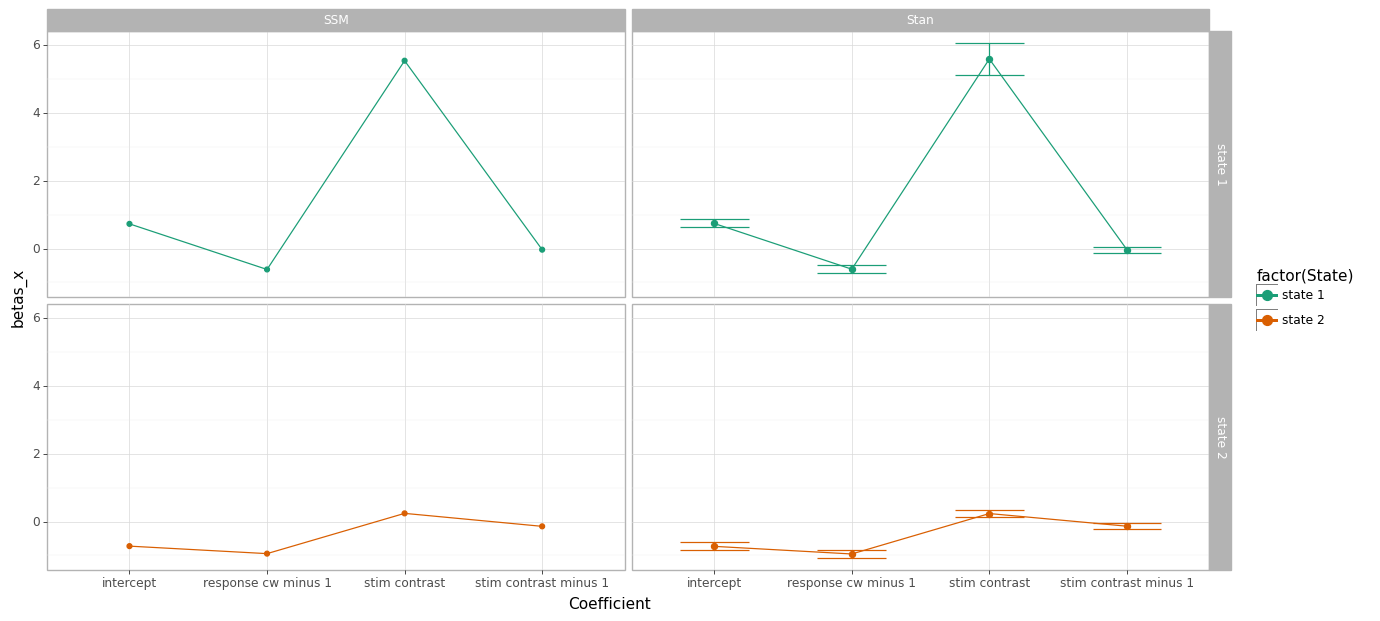

<ggplot: (391219941)>

In [7]:
def stat_hdi(series, hdi_prob = 0.89):
    """ Compute a HDI (highest density interval) for a pandas.series """
    data = series.values
    min, max = az.hdi(data, hdi_prob=hdi_prob)
    return pd.DataFrame({"ymin": [min], "ymax": [max]})

(ggplot(draws, aes('Coefficient', 'betas_x', color='factor(State)'))
 + facet_grid('State ~ Source')
 + stat_summary()
 + stat_summary(geom = "geom_errorbar", fun_data = stat_hdi)
 + stat_summary(geom = "geom_line",  group="state")
 # now the same for the ssm data (only points)
 + geom_point(data=ssm_df, mapping=aes("Coefficient", "value"), group="State")
 + geom_line(data=ssm_df, mapping=aes("Coefficient", "value"), group="State")
 + theme_light()
 + scale_color_brewer(type='qual', palette=2)
 + theme(figure_size = (15, 7))
 )

**I think that's pretty neat! We're essentially doing the same inference, but we're getting all the information about how certain we are for free!**